# 反卷积法寻找光电子时间戳

* * *
## 基础假设

1. PMT对光电子入射的响应是线性时不变的

## 技术路线

1. 使用训练集，寻找PMT对单光电子(photoelectron)入射的标准响应模型(standard model)
2. 使用离散傅立叶变换(discrete Fourier transform, DFT)
   求波形(waveform)对标准响应模型的卷积参数，将卷积参数作为光电子入射的概率

* * *
## 1.*寻找标准响应模型*（与“参数拟合法寻找光电子时间戳”相同）

* * *
## 2.*离散傅立叶变换法拟合参数*

### 模块及文件路径导入

In [1]:
import numpy as np
import h5py
from scipy.fftpack import fft,ifft

fipt = "/Users/xudachengthu/Downloads/GHdataset/finalcontest_data/ztraining-0.h5"
#fipt = "/Users/xudachengthu/Downloads/GHdataset/finalcontest_data/zincm-problem.h5"
fopt = "/Users/xudachengthu/Downloads/GHdataset/submission/first-submission-spe-fin-2.h5"
single_pe_path_old = '/Users/xudachengthu/Downloads/GH_LargeDoc/single_pe.h5'

### 离散傅立叶变换基础参数设定

In [2]:
Length_pe = 1029
KNIFE = 0.1
EXP = 5

### 定义数据格式

In [3]:
opd = [('EventID', '<i8'), ('ChannelID', '<i2'), ('PETime', 'f4'), ('Weight', 'f4')]

### 提取标准响应模型

In [4]:
speFile = h5py.File(single_pe_path_old, 'r')
spemean = np.mean(speFile['Sketchy']['speWf'], axis = 0)

#计算波形数据中电压的基线，进行波形反转
base_vol = np.mean(spemean[70:120])
stdmodel = np.subtract(base_vol, spemean[20:120])
#避免出现负数并减小波动
stdmodel = np.multiply(np.around(np.divide(stdmodel, 0.05)), 0.05)
stdmodel = np.abs(np.where(stdmodel >= 0, stdmodel, 0))

speFile.close()
model = stdmodel
model_raw = np.concatenate([model, np.zeros(Length_pe - len(model))])

### 压缩标准响应模型

In [5]:
core = model / np.max(model)
for i in range(len(core)):
    core[i] = pow(core[i], EXP)
model = core * np.max(model)
model = np.where(model > 0.02, model, 0)
model = np.concatenate([model, np.zeros(Length_pe - len(model))])

### 压缩前后标准响应模型的比较

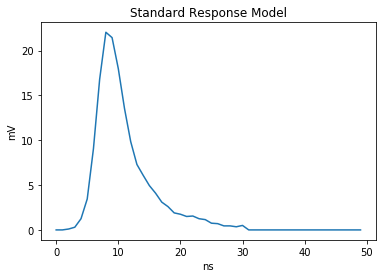

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.clf()
plt.plot(model_raw[0:50])
plt.title("Standard Response Model")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

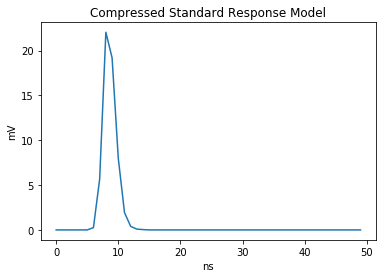

In [7]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(model[0:50])
plt.title("Compressed Standard Response Model")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

### 路径配置

In [8]:
ipt = h5py.File(fipt, 'r')
opt = h5py.File(fopt, "w")
ent = ipt['Waveform'][0 : 2000]

dt = np.zeros(Length_pe, dtype = opd)
start = 0
end = 0

### 提取波形的频域信息（快速傅立叶变换，FFT）

In [9]:
wf = ent[1]['Waveform']

wf_input = np.subtract(np.mean(wf[900:1000]), wf)
wf_input = np.where(wf_input > 0, wf_input, 0)

wf_k = fft(wf_input)

### 离散傅立叶变换的公式

$$ X(k) =\sum_{n=0}^{N-1} x(n) W_{N}^{n k} \quad 0 \leqslant k \leqslant N-1 $$

$$ x(n) = \frac{1}{N} \sum_{k=0}^{N-1} X(k) W_{N}^{-n k} \quad 0 \leqslant n \leqslant N-1 $$

其中：

$$ W_{N} = \mathrm{e}^{-j \frac{2 \pi}{N}} $$

### 生成标准响应模型的频域信息

In [10]:
model_k = fft(model)

### 生成光电子分布信息的频谱

In [11]:
spec = np.divide(wf_k, model_k)

### 生成光电子分布信息（逆向快速傅立叶变换，IFFT）

In [12]:
pf = ifft(spec)
pf = pf.real

### 去除过小的分布值

In [13]:
pf = np.where(pf > KNIFE, pf, 0).reshape(1, Length_pe)

lenpf = np.size(np.where(pf > 0))
if lenpf == 0:
    pf[300] = 1

### 存储数据

In [14]:
pet = np.where(pf > 0)[1]
lenpf = np.size(pet)

pwe = pf[pf > 0]
end = start + lenpf

dt['PETime'][start:end] = pet
dt['Weight'][start:end] = pwe
dt['EventID'][start:end] = ent[0]['EventID']
dt['ChannelID'][start:end] = ent[0]['ChannelID']
start = end
    
dt = dt[np.where(dt['Weight'] > 0)]
opt.create_dataset('Answer', data = dt, compression='gzip')

ipt.close()
opt.close()

* * *
## 生成的概率分布

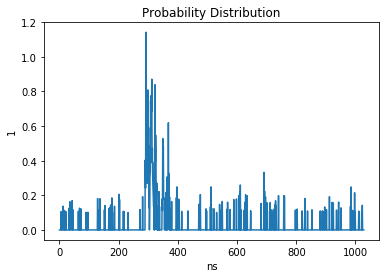

In [15]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(pf[0, :])
plt.title("Probability Distribution")
plt.xlabel('ns')
plt.ylabel('1')
plt.show()

## 真实的分布

[294 294 300 310 313 325 351 369]


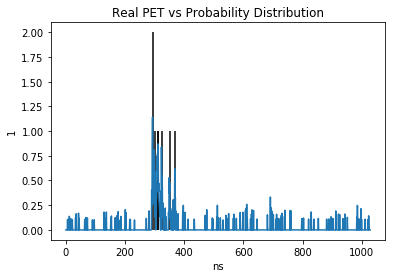

In [16]:
import pandas as pd
import h5py
ipt = h5py.File(fipt, 'r')
ent = ipt['Waveform']

eid = ent[1]['EventID']
ch = ent[1]['ChannelID']
th = pd.read_hdf(fipt,"GroundTruth")
rh = th[0 : 2000]
pe = th.query("EventID=={} & ChannelID=={}".format(eid, ch))

ipt.close()
pt = pe['PETime'].values
unique, c = np.unique(pt, return_counts = True)
#pt = pt[(pt >= 200) & (pt < 500)]
plt.xlim((0, 1029))
print(pt)

plt.clf()
plt.vlines(unique, ymin = 0, ymax = c)
plt.plot(pf[0, :])
plt.title("Real PET vs Probability Distribution")
plt.xlabel('ns')
plt.ylabel('1')
plt.show()

## 原始波形和基于标准响应模型的预测波形之间的比较

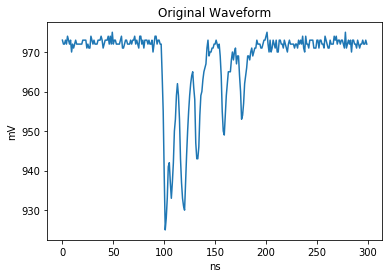

In [17]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(wf[200:500])
plt.title("Original Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

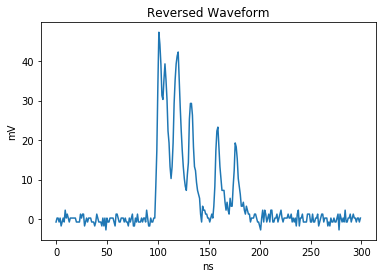

In [18]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot((np.mean(wf[900:1000]) - wf)[200:500])
plt.title("Reversed Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

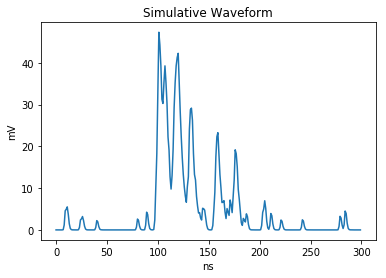

In [19]:
mtray = np.concatenate((np.zeros(Length_pe), model[0 : 50], np.zeros(Length_pe)))
loperator = np.concatenate([mtray[Length_pe - i : 2 * Length_pe + 50 - i] 
                            for i in range(Length_pe)]).reshape(Length_pe, Length_pe + 50)
import matplotlib.pyplot as plt
plt.clf()
plt.plot(np.matmul(pf, loperator)[0, 200:500])
plt.title("Simulative Waveform")
plt.xlabel('ns')
plt.ylabel('mV')
plt.show()

In [20]:
exit()

* * *
## 备注

1. 此方法的W-dist统计值多在 3.2 - 3.7 之间
2. 离散傅立叶变换所取的基础参数均可以用穷举法求出最优参数组合

## 优点

1. 使用快速傅立叶变换，生成速度快，对1,605,330条波形，使用实验室服务器（CPU: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz），所需时间为80min左右

## 缺点

1. 预测波形和实际输入波形有一定程度的差异
2. 未考察各channel的特异性

## 改进的方向

1. 考察各channel的特异性
2. 使用多模型进行参数拟合，以避免电压变化的模式的统计涨落对结果的不良影响，并尽量按整数拟合
3. 消除波形(waveform)中的噪声